In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))
include(srcdirx("DataProcessing.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using DynamicAxisWarping
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using CategoricalArrays
# using ScikitLearn
using ShapML
using DataFrames
using Combinatorics

In [3]:
statmod = pyimport("statsmodels.graphics.mosaicplot")

plt = pyimport("matplotlib.pyplot")

pd = pyimport("pandas")

shap = pyimport("shap")

PyObject <module 'shap' from '/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/shap/__init__.py'>

In [4]:
function cond_save(dir,fig,cond)
    if cond
        CairoMakie.save(dir,fig)
    end
end

cond = false

false

In [5]:
color_scheme = cgrad(:tab10,categorical = true);

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

color_name = ["purple","red","green","yellow","blue","pink"]

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

#################################################################

weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

ci_indices_dict = Dict(ci=>i for (i,ci) in enumerate(CartesianIndex.(weight_indices)));

In [6]:
# data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));

data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData_beta_1_mg_250k.jld2"));

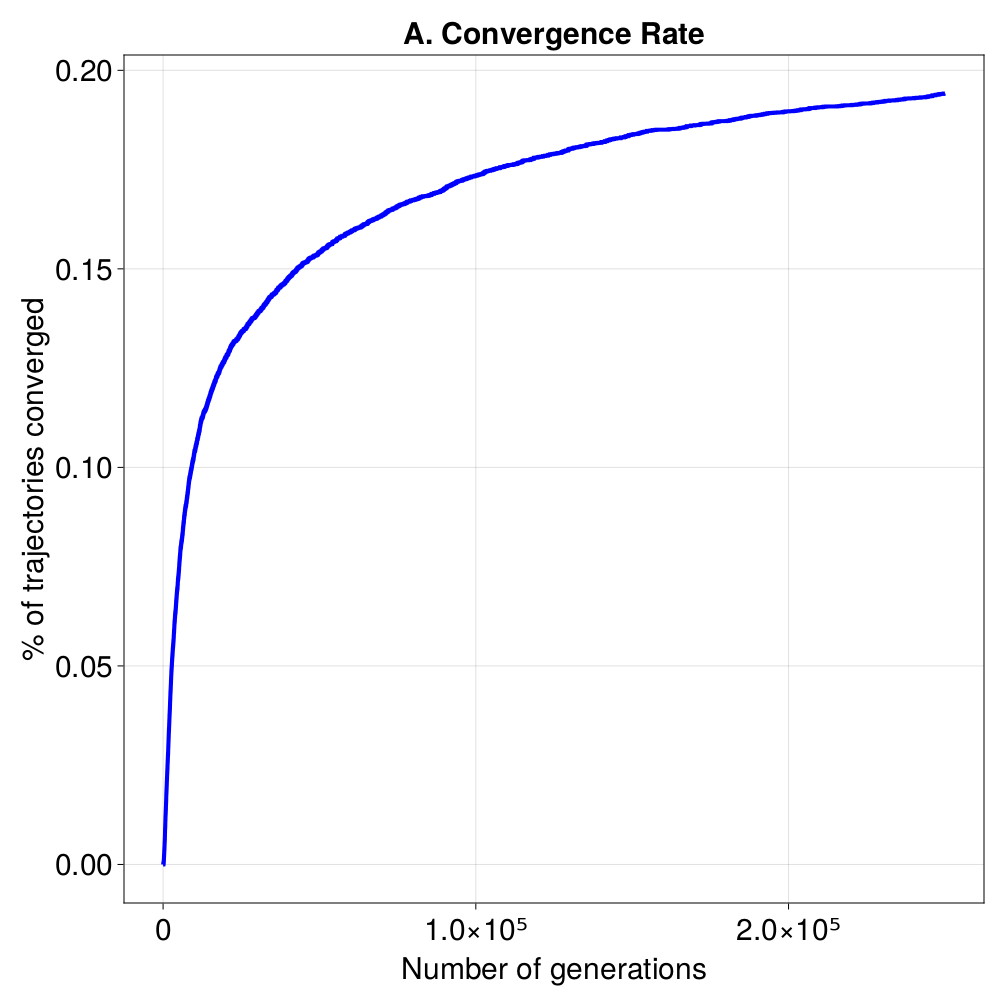

In [7]:
conv = copy(data["converged"]);

conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

cond_save(plotsdirx("Experiment_1","ConvergenceRates.png"),fig,cond)

fig

In [8]:
fitness_traj_b = copy(data["fitness_traj"])[conv];

fitness_traj = map(t->map(x->x[2]+x[1],unique(t)),fitness_traj_b);

geno_traj = map(x->unique(x,dims =2),data["geno_traj"])[conv];

initial_fitness = fitness_traj[1][1];

initial_genotype = geno_traj[1][:,1];

In [9]:
fundamental_networks_dyn_cell = pmap(nt->get_rel_dyn_vector(nt[1],nt[2],n_steps,save_id),zip(fundamental_networks,fundamental_networks_t2s));
fundamental_networks_dyn_av = pmap(nt->get_av_dyn_vector(nt[1],nt[2],n_steps,n_segments),zip(fundamental_networks,fundamental_networks_t2s));

fund_X_cell = reduce(hcat,fundamental_networks_dyn_cell)
fund_X_av = reduce(hcat,fundamental_networks_dyn_av);


sim_m = copy(data["fund_dmat_cell"])

n_traj = sum(conv)

dmat_av = copy(data["dmat_av"]);

end_networks = map(v->v[:,end],data["geno_traj"]);

mind_class =  map(x->fundamental_labels[x[2]],argmin(sim_m,dims =2)) 

incl_top = reduce(hcat,map(en->[test_inclusion(en,vec(network_topology_dict[n])) for n in fundamental_topologies],end_networks)) |> transpose |> collect;

dyn_top_mind = zeros(Int,length(end_networks),length(fundamental_topologies))

top_assignment_mind = map(x->fund_top_ndict[x],mind_class)

for (net,t) in enumerate(top_assignment_mind)
    dyn_top_mind[net,t] = 1
end

########

class_labels = map(x->fund_top_dict[x],determine_class(incl_top,dyn_top_mind))[conv];

class_labels_u = unique(class_labels);

color_dict = Dict(i=>color_name[fund_top_ndict[i]+1] for i in class_labels_u)

Dict{String, String} with 4 entries:
  "bistable"      => "blue"
  "feed_forward"  => "red"
  "classical"     => "pink"
  "No assignment" => "purple"

In [10]:
mut_types = data["mut_type"][conv];
mut_choices = data["mut_choices"][conv]

dmc_re = map(mct->map(mc->map(x->ci_indices_dict[x],mc),mct),mut_choices)

dmc_re_sp = map(mct->map(x->sortperm(x),mct),dmc_re)

mut_choices_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(dmc_re,dmc_re_sp)];

mut_types_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(mut_types,dmc_re_sp)];

In [11]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),fitness_traj)))

n_bin = 10

hist_edges = zeros(n_bin+1)

hist_edges[1] = initial_fitness

hist_edges[2:n_bin] .= LinRange(initial_fitness+eps(),0.9,n_bin-1) |> collect

hist_edges[n_bin+1] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),unique(traj)),fitness_traj);

wait_times = map(fb->unique(i -> fb[i], 1:length(fb)),fitness_traj_b)

wait_times_mutant = map(x->x[2:end] .- x[1:end-1],wait_times);

In [12]:
clust_labels = copy(class_labels);

In [13]:
mut_id = map(x->get_mutation_id(unique(x,dims = 2)),geno_traj);

mut_id_labels = map(v->map(x->weight_names[x],v),mut_id);

mut_id_labels = map(v->map(x->(n_mut=length(x),mut_id_name=join(map(i->weight_names[i],x),"|"),mut_id=x),v),mut_id);

mut_dist = map(x->get_mutant_dist(unique(x,dims = 2)),geno_traj);

fitness_delta = map(x->get_fitness_delta(unique(x)),fitness_traj);

actual_fitness = map(x->x[1:end-1],fitness_traj);

actual_networks = map(x->[x[:,j] for j in 1:size(x[:,1:end-1],2)],geno_traj);

actual_mutant = map(x->[j for j in 1:size(x[:,1:end-1],2)],geno_traj);

mut_id_label_type = [[(mut_type=mut_typ,midl...) for (mut_typ,midl) in zip(mut_types_ro[i],mut_id_labels[i])] for i in 1:length(mut_id_labels)];

mut_id_wait_time = [[(wait_time=wt,midl...) for (wt,midl) in zip(wait_times_mutant[i],mut_id_label_type[i])] for i in 1:length(mut_id_label_type)];

mut_id_size_label = [[(mut_size=mut_size,midl...) for (mut_size,midl) in zip(mut_dist[i],mut_id_wait_time[i])] for i in 1:length(mut_id_wait_time)];

mut_id_size_label_am = [[(mut_number=mut_number,midl...) for (mut_number,midl) in zip(actual_mutant[i],mut_id_size_label[i])] for i in 1:length(mut_id_size_label)];

mut_id_size_label_an = [[(existing_network=network,midl...) for (network,midl) in zip(actual_networks[i],mut_id_size_label_am[i])] for i in 1:length(mut_id_size_label_am)];

mut_id_size_label_af = [[(existing_fitness=fitness,midl...) for (fitness,midl) in zip(actual_fitness[i],mut_id_size_label_an[i])] for i in 1:length(mut_id_size_label_an)];

mut_id_size_label_fb = [[(fitness_bin=fb,midl...) for (fb,midl) in zip(fitness_routes[i],mut_id_size_label_af[i])] for i in 1:length(mut_id_size_label_af)];

mut_id_size_label_fb_ft = [[(fitness_delta=fd,midl...) for (fd,midl) in zip(fitness_delta[i],mut_id_size_label_fb[i])] for i in 1:length(mut_id_size_label_fb)];

mut_id_size_label_fb_cc = [[(cluster_id=clust_labels[i],midl...) for midl in mut_id_size_label_fb_ft[i]] for i in 1:length(mut_id_size_label_fb_ft)];

mut_info = [[(traj_id=i,midl...) for midl in mut_id_size_label_fb_cc[i]] for i in 1:length(mut_id_size_label_fb_cc)];

all_mut_info = reduce(vcat,mut_info);

In [14]:
function evaluate_epistasis_pairwise(mut_tuple,grn_parameters,development,fitness_function)

    n_mut_to_evaluate = length(mut_tuple[:mut_id])

    if typeof(mut_tuple[:existing_fitness]) == Tuple{Float64,Float64}
        existing_fitness = mut_tuple[:existing_fitness][1] + mut_tuple[:existing_fitness][2]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    else
        existing_fitness = mut_tuple[:existing_fitness]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    end

    new_mutant_fitness = []

    new_mutant_weight_signs = []

    new_mutant_noise_signs = []

    for n in 1:n_mut_to_evaluate

        new_network = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][n],mut_tuple[:mut_size][n],mut_tuple[:mut_type][n])

        mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

        nmf = fitness_function(mutant.phenotype)

        if typeof(nmf) == Tuple{Float64,Float64}
            nmf = nmf[1] + nmf[2]
        end

        push!(new_mutant_fitness,nmf)
        push!(new_mutant_weight_signs,sign(new_network[mut_tuple[:mut_id][n]]))
        push!(new_mutant_noise_signs,sign(mut_tuple[:mut_size][n]))

    end

    # return  existing_fitness,og_mutant_fitness,Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],new_mutant_fitness))

    r = Dict()

    r1 =  Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],(new_mutant_fitness .+ 2) ./ (og_mutant_fitness + 2)))

    r1[-1] = mut_tuple[:existing_fitness] + 2
    r1[-2] = mut_tuple[:fitness_delta]

    r2 = Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],new_mutant_weight_signs))
    r3 = Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],new_mutant_noise_signs))

    return r1, r2, r3
end

function evaluate_epistasis_class(mut_tuple,grn_parameters,development,fitness_function)

    n_mut_to_evaluate = length(mut_tuple[:mut_id])

    if typeof(mut_tuple[:existing_fitness]) == Tuple{Float64,Float64}
        existing_fitness = mut_tuple[:existing_fitness][1] + mut_tuple[:existing_fitness][2]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    else
        existing_fitness = mut_tuple[:existing_fitness]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    end

    new_mutant_fitness = []

    new_mutant_weight_signs = []

    new_mutant_noise_signs = []

    for n in 1:n_mut_to_evaluate

        new_network = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][n],mut_tuple[:mut_size][n],mut_tuple[:mut_type][n])

        mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

        nmf = fitness_function(mutant.phenotype)

        if typeof(nmf) == Tuple{Float64,Float64}
            nmf = nmf[1] + nmf[2]
        end

        push!(new_mutant_fitness,nmf)
        push!(new_mutant_weight_signs,sign(new_network[mut_tuple[:mut_id][n]]))
        push!(new_mutant_noise_signs,sign(mut_tuple[:mut_size][n]))

    end

    # return  existing_fitness,og_mutant_fitness,Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],new_mutant_fitness))

    accept_mutation = new_mutant_fitness .> existing_fitness

    if accept_mutation[1] & accept_mutation[2]

        if maximum(new_mutant_fitness) > og_mutant_fitness
            r1 = Dict(mt=>:nonsyn for mt in mut_tuple[:mut_id])
        else
            r1 = Dict(mt=>:syn for mt in mut_tuple[:mut_id])
        end

    elseif (accept_mutation[1] & !accept_mutation[2])
        r1 = Dict(mut_tuple[:mut_id][1]=>:carrier,mut_tuple[:mut_id][2]=>:hitchhike)
    elseif (!accept_mutation[1] & accept_mutation[2])
        r1 = Dict(mut_tuple[:mut_id][1]=>:hitchhike,mut_tuple[:mut_id][2]=>:carrier)
    else
        r1 = Dict(mt=>:rse for mt in mut_tuple[:mut_id])
    end

    return r1
end

function fixation_prob_non_negative(fitness_delta,β)
    return max(0.,fixation_probability(fitness_delta,β))
end

function evaluate_epistasis(mut_tuple,geno_traj,fitness_traj,grn_parameters,development,fitness_function)

    n_mut_max = mut_tuple[:mut_number] - 1

    new_mutant_fitness_delta = []
    new_mutant_fitness_delta_rel = []
    new_mutant_accept_prob = []

    for i in 1:n_mut_max

        new_network = noise_specified(geno_traj[mut_tuple[:traj_id]][:,i],mut_tuple[:mut_id],mut_tuple[:mut_size],mut_tuple[:mut_type])

        mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

        nmf = fitness_function(mutant.phenotype)

        if typeof(nmf) == Tuple{Float64,Float64}
            nmf = nmf[1] + nmf[2]
        end

        push!(new_mutant_fitness_delta,(mut_tuple[:mut_number] - i,nmf - fitness_traj[mut_tuple[:traj_id]][i]))
        push!(new_mutant_fitness_delta_rel,(mut_tuple[:mut_number] - i,(nmf - fitness_traj[mut_tuple[:traj_id]][i])/mut_tuple[:fitness_delta]))
        push!(new_mutant_accept_prob,(mut_tuple[:mut_number] - i,fixation_prob_non_negative(nmf - fitness_traj[mut_tuple[:traj_id]][i],β)/fixation_prob_non_negative(mut_tuple[:fitness_delta],β)))

    end

    return [new_mutant_accept_prob,new_mutant_fitness_delta_rel,new_mutant_fitness_delta]
end

function characterise_epi(d)
    v = values(d) |> collect

    if :rse in v
        return (1,"RSE")
    elseif :carrier in v
        return (2,"Carrier/Hitchhike")
    else
        return (3,"Syn/NonSyn")
    end

end

characterise_epi (generic function with 1 method)

In [15]:
function mask(network,topology)

    new_network = copy(network)

    z0 = findall(x->x == 0,topology)

    new_network[z0] .= 0.

    return new_network

end

mask (generic function with 1 method)

In [16]:
hamming_distance_all = [reduce(hcat,map(en->[Distances.evaluate(Hamming(),mask(sign.(en),vec(network_topology_dict[n])),vec(network_topology_dict[n])) for n in fundamental_topologies],eachcol(geno_traj[i]))) |> collect for i in 1:length(geno_traj)];

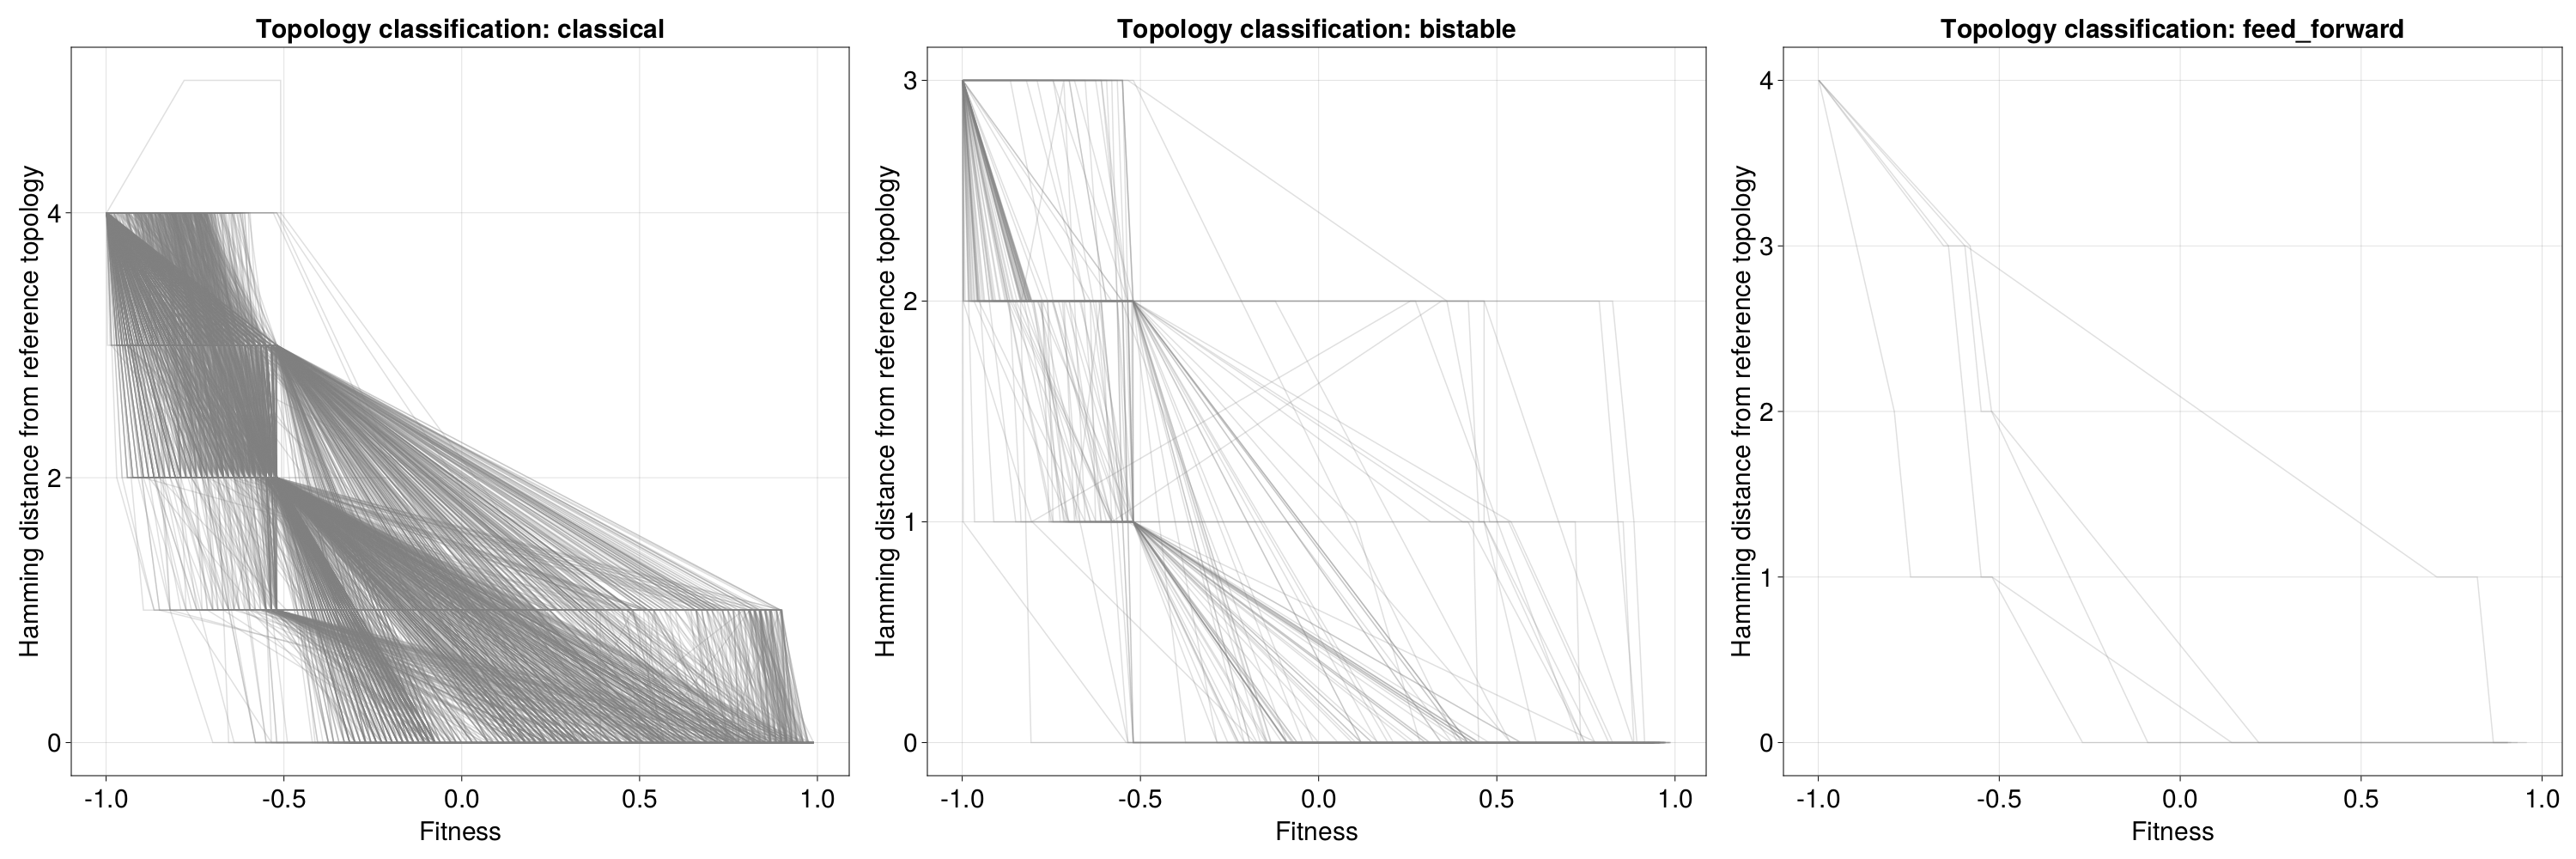

In [17]:
fig = CairoMakie.Figure(resolution = (3000,1000),fontsize = 30.)

for (n,top) in enumerate(filter(x->x!= "No assignment",class_labels_u))

    ax = Axis(fig[1,n],title = "Topology classification: " * top, ylabel = "Hamming distance from reference topology",xlabel = "Fitness")

    cl_hm = [[(f,h[fund_top_ndict[top]]) for (h,f) in zip(eachcol(hamming_distance_all[i]),fitness_traj[i])] for i in 1:length(fitness_traj)];

    for dp in cl_hm[class_labels .== top]

        CairoMakie.lines!(ax,dp,color = (:grey, 0.25))
    end

end

cond_save(plotsdirx("Experiment_1/BranchingPoints","HammingDistanceFromReference.png"),fig,true)

fig

In [18]:
stripe_achieved = map(x->minimum(findall(x->x[1] == 0.,unique(x))),fitness_traj_b);

zham_id =  map(hd->findall(y->any(y .== 0),eachcol(hd)),hamming_distance_all);

zham_achieved = [length(x) == 0 ? Inf : minimum(x) for x in zham_id];

zham_achieved_n = [length(x) == 0 ? -1 : minimum(x) for x in zham_id];

#####################

zham_le = zham_achieved .<= stripe_achieved

zham_l = zham_achieved .< stripe_achieved

zham_equals = zham_achieved .== stripe_achieved

zham_n = zham_achieved .== Inf

zham_g = (zham_achieved .> stripe_achieved) .& .!(zham_n);

@assert sum(zham_l) + sum(zham_equals) + sum(zham_n) + sum(zham_g) == length(fitness_traj)

zham_time_class = zeros(Int,length(fitness_traj))

zham_time_class[zham_l] .= 1
zham_time_class[zham_equals] .= 2
zham_time_class[zham_g] .= 3
zham_time_class[zham_n] .= 4

zham_s = .!zham_n;

sum(zham_s) / length(zham_s)

0.45068246201390677

In [19]:
zham_top = [findall(x->x==0,hd[:,zid]) for (zid,hd) in zip(zham_achieved[zham_s],hamming_distance_all[zham_s])]

end_top = [findall(x->x==0,hdm[:,end]) for hdm in hamming_distance_all[zham_s]]

zham_incl_end =  [all([x in etop for x in ztop]) for (ztop,etop) in zip(zham_top,end_top)]

zham_is_end =  [etop == ztop for (ztop,etop) in zip(zham_top,end_top)];

#########################

zham_trans = findall(zham_s) 

zham_trans_id =  map(x->x-1,zham_achieved[zham_trans])

zham_mutation = [filter(x->(x[:traj_id] == t) && (x[:mut_number] == m),all_mut_info)[1] for (t,m) in zip(zham_trans,zham_trans_id)];

zham_trans_hd = [hamming_distance_all[t][:,m] for (t,m) in zip(zham_trans,zham_trans_id)];

#########################

zham_trans_min_hd = map(x->minimum(x),zham_trans_hd);

zham_trans_min_hd_top = map(x->argmin(x),zham_trans_hd)

zham_top_incl_min_hd =  [all([x in etop for x in ztop]) for (ztop,etop) in zip(zham_trans_min_hd_top,zham_top)]

#########################

stripe_trans_id = map(x->x-1,stripe_achieved[zham_trans])

stripe_mutation = [filter(x->(x[:traj_id] == t) && (x[:mut_number] == m),all_mut_info)[1] for (t,m) in zip(zham_trans,stripe_trans_id)];

In [20]:
print(unique(end_top))

[[5], [4], Int64[], [1, 2], [1]]

In [21]:
print(unique(zham_top))

[[5], [4], [1, 2], [1], [2]]

In [22]:
# top_types = unique(reduce(vcat,[zham_top,end_top]))

# top_type_ndict = Dict(t=>n for (n,t) in enumerate(top_types))

# top_type_ndictr = Dict(l=>f for (f,l) in top_type_ndict)

# top_type_dict = Dict(t=> length(t) > 0 ? join([fund_top_dict[i] for i in t], "|") : "No assignment" for (n,t) in enumerate(top_types))

# top_type_cdict = Dict("feed_forward"=>"red","No assignment"=>"purple","classical"=>"pink","bistable"=>"blue","mutual_inh"=>"green","feed_forward|mutual_inh"=>"orange");

In [23]:
epi_result_branch = map(x->evaluate_epistasis_class(x,grn_parameters,DefaultGRNSolver(),fitness_function),filter(x->x[:n_mut] == 2,zham_mutation));

epi_class_branch = map(x->characterise_epi(x)[1],epi_result_branch);

epi_branch_plot_data = [i for i in zip(map(x->x[:cluster_id],zham_mutation),epi_class_branch)];

In [24]:
mut_new = condition_data_incl_return_tuples([],[],[:mut_type],[:new],all_mut_info);
mut_existing = condition_data_excl_return_tuples([],[],[:mut_type],[:new],all_mut_info);

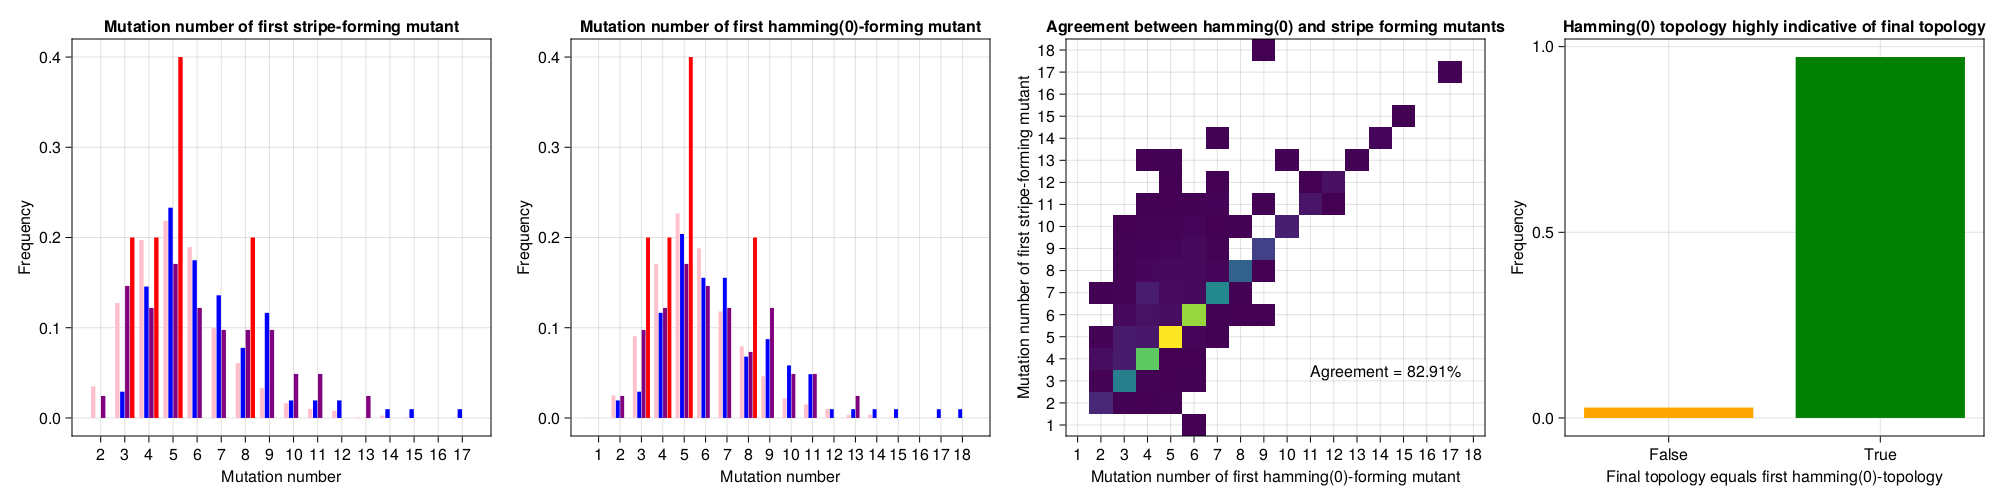

In [25]:
fig = CairoMakie.Figure(resolution = (2000,500))

d1 = map(x->x[:mut_number],stripe_mutation)
d2 = map(x->x[:mut_number],zham_mutation)

min_mut = minimum(reduce(vcat,[d1,d2]))
max_mut = maximum(reduce(vcat,[d1,d2]))

drange = min_mut:max_mut

d = zeros(length(drange),length(drange))

for (ni,i) in enumerate(drange)
    for (nj,j) in enumerate(drange)
        x = count(x->(x[1] == i) & (x[2] == j),zip(d1,d2))
        d[ni,nj] = x .!= 0 ? x : NaN

    end
end

ax1 = Axis(fig[1,1], title = "Mutation number of first stripe-forming mutant", xlabel = "Mutation number", ylabel = "Frequency")
create_bar_from_tuples!(ax1,map(x->(x[:cluster_id],x[:mut_number]),stripe_mutation),color_dict,true)

ax1.xticks = (minimum(d1):1:maximum(d1),string.(minimum(d1):1:maximum(d1)))

ax2 = Axis(fig[1,2], title = "Mutation number of first hamming(0)-forming mutant", xlabel = "Mutation number", ylabel = "Frequency")
create_bar_from_tuples!(ax2,map(x->(x[:cluster_id],x[:mut_number]),zham_mutation),color_dict,true)

ax2.xticks = (minimum(d2):1:maximum(d2),string.(minimum(d2):1:maximum(d2)))

ax3 = Axis(fig[1,3], xlabel = "Mutation number of first hamming(0)-forming mutant", ylabel = "Mutation number of first stripe-forming mutant",title = "Agreement between hamming(0) and stripe forming mutants")
CairoMakie.heatmap!(ax3,d)

CairoMakie.text!(ax3,[Point2f(11,3)],text = ["Agreement = " * string(round(sum(zham_equals[zham_s])*100/sum(zham_s),digits =2)) * "%"])

ax3.xticks = (drange, string.(drange))
ax3.yticks = (drange, string.(drange))

ax4 = Axis(fig[1,4], ylabel = "Frequency", xlabel = "Final topology equals first hamming(0)-topology",title = "Hamming(0) topology highly indicative of final topology")
CairoMakie.barplot!(ax4,[0,1],[countmap(zham_incl_end)[x]/length(zham_incl_end) for x in [0,1]],color = [:orange,:green])

ax4.xticks = (0:1,["False","True"])

# d1 = map(x->top_type_dict[x],zham_top)

# ax4 = Axis(fig[1,4], ylabel = "Frequency")
# create_bar_from_tuples!(ax4,[x for x in zip(d1,zham_incl_end)],top_type_cdict,true)

# ax4.xticks = (0:1,["Topology change","Remained hamming(0)-topology"])

cond_save(plotsdirx("Experiment_1/BranchingPoints","StripeVsHammingZ.png"),fig,true)

fig

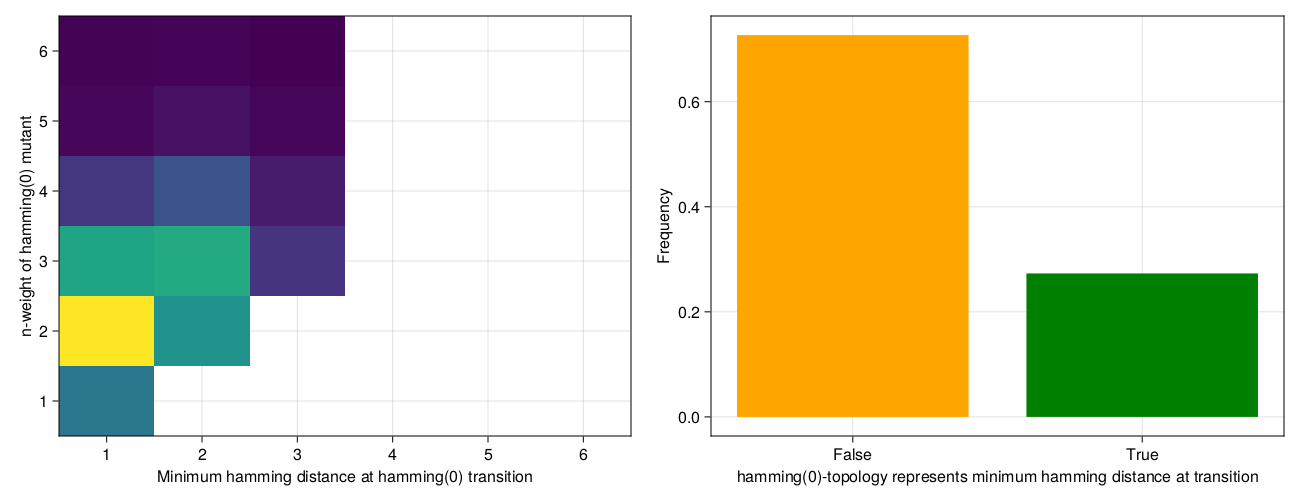

In [26]:
d1 = copy(zham_trans_min_hd)
d2 = map(x->x[:n_mut],zham_mutation)

min_mut = minimum(reduce(vcat,[d1,d2]))
max_mut = maximum(reduce(vcat,[d1,d2]))

drange = min_mut:max_mut

d = zeros(length(drange),length(drange))

for (ni,i) in enumerate(drange)
    for (nj,j) in enumerate(drange)
        x = count(x->(x[1] == i) & (x[2] == j),zip(d1,d2))
        d[ni,nj] = x .!= 0 ? x : NaN
    end
end

fig = CairoMakie.Figure(resolution = (1300,500))

ax1 = Axis(fig[1,1], xlabel = "Minimum hamming distance at hamming(0) transition", ylabel = "n-weight of hamming(0) mutant")
CairoMakie.heatmap!(ax1,d)

ax1.xticks = (1:6, string.(1:6))
ax1.yticks = (1:6, string.(1:6))

ax2 = Axis(fig[1,2], ylabel = "Frequency", xlabel = "hamming(0)-topology represents minimum hamming distance at transition")
CairoMakie.barplot!(ax2,[0,1],[countmap(zham_top_incl_min_hd)[x]/length(zham_top_incl_min_hd) for x in [0,1]],color = [:orange,:green])

ax2.xticks = (0:1,["False","True"])

cond_save(plotsdirx("Experiment_1/BranchingPoints","HammingGraphNaivelyNonInformative.png"),fig,true)

fig

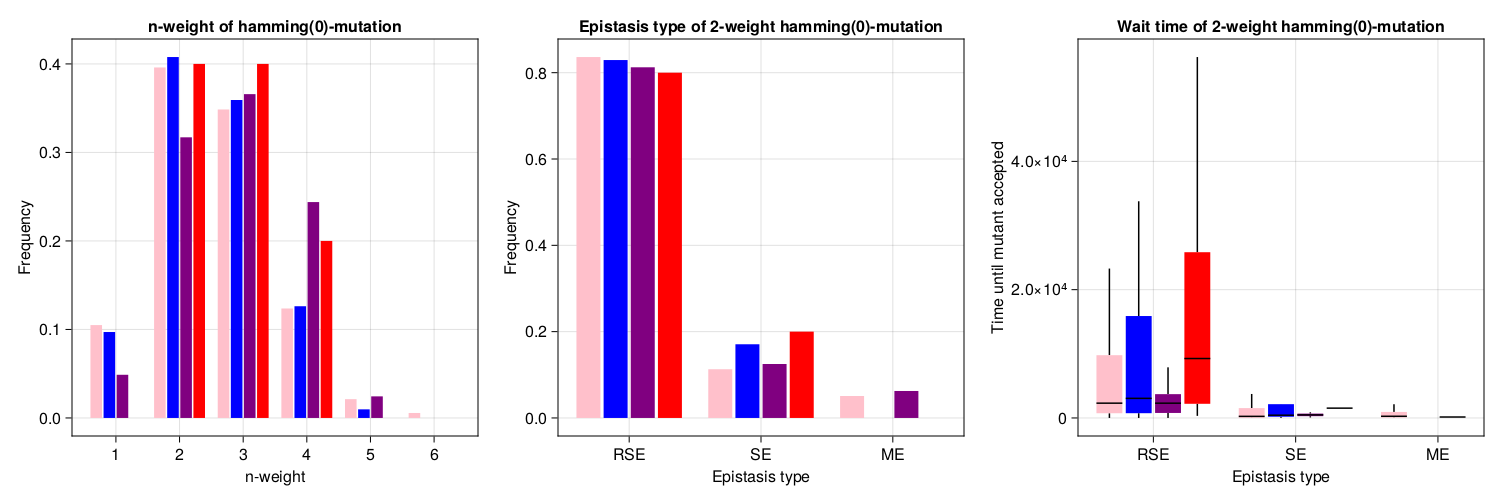

In [27]:
# Add number of mutation distribution for all mutations as comparison

fig = CairoMakie.Figure(resolution = (1500,500))

ax1 = Axis(fig[1,1], xlabel = "n-weight", ylabel = "Frequency",title = "n-weight of hamming(0)-mutation")
create_bar_from_tuples!(ax1,map(x->(x[:cluster_id],x[:n_mut]),zham_mutation),color_dict,true)

ax2 = Axis(fig[1,2], xlabel = "Epistasis type", ylabel = "Frequency",title = "Epistasis type of 2-weight hamming(0)-mutation")
create_bar_from_tuples!(ax2,epi_branch_plot_data,color_dict,true)

ax2.xticks = (1:3,["RSE","SE","ME"])

# linkyaxes!([ax1,ax2,ax3]...)

ax3 = Axis(fig[1,3], xlabel = "Epistasis type", ylabel = "Time until mutant accepted",title = "Wait time of 2-weight hamming(0)-mutation")

wt = map(x->x[:wait_time],filter(x->x[:n_mut] == 2,zham_mutation))

reorder_dict = Dict("classical"=>1,"bistable"=>2,"No assignment"=>3,"feed_forward"=>4,"mutual_inh" => 5)

CairoMakie.boxplot!(ax3,epi_class_branch,wt,dodge = map(x->reorder_dict[x],first.(epi_branch_plot_data)),color = map(x->color_dict[x],first.(epi_branch_plot_data)),show_outliers = false)

ax3.xticks = (1:3,["RSE","SE","ME"])

cond_save(plotsdirx("Experiment_1/BranchingPoints","EpistasisTypes.png"),fig,true)

fig

# boxplot time to find mutant for RSE vs SE vs ME, also potentially by topological classification
# How does the n-weight of the hamming(0) mutant correlate with the minimimum hamming distance to a given topology prior to the transition?
#

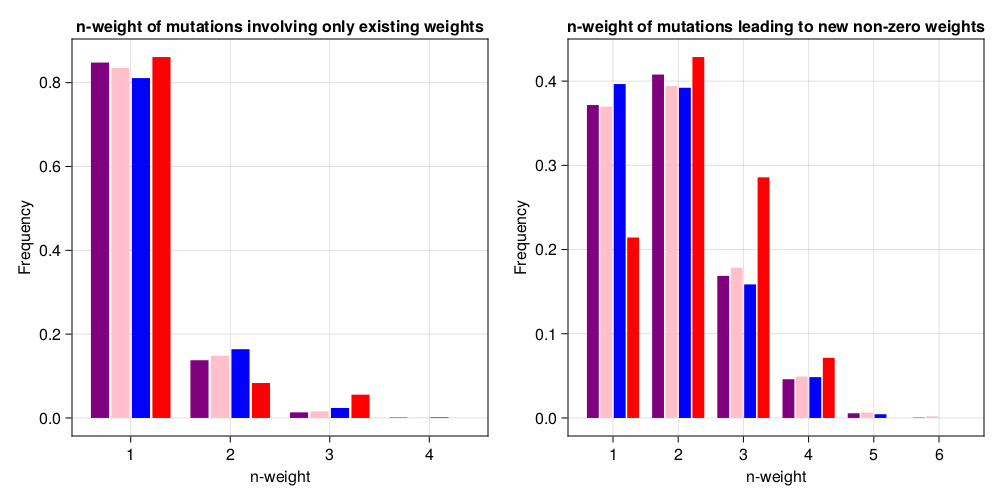

In [28]:
fig = CairoMakie.Figure(resolution = (1000,500))

ax1 = Axis(fig[1,1], xlabel = "n-weight", ylabel = "Frequency",title = "n-weight of mutations involving only existing weights")
create_bar_from_tuples!(ax1,map(x->(x[:cluster_id],x[:n_mut]),mut_existing),color_dict,true)

ax2 = Axis(fig[1,2], xlabel = "n-weight", ylabel = "Frequency",title = "n-weight of mutations leading to new non-zero weights")
create_bar_from_tuples!(ax2,map(x->(x[:cluster_id],x[:n_mut]),mut_new),color_dict,true)

fig

In [29]:
branch_networks = map(x->x[:existing_network],zham_mutation);

# second_mutation = [filter(x->(x[:traj_id] == t) && (x[:mut_number] == 2),all_mut_info)[1] for (t,m) in zip(zham_trans,zham_trans_id)];

# branch_networks = map(x->x[:existing_network],second_mutation);

# branch_t2s = [t[id] for (t,id) in zip(data["t2s_traj"][conv][zham_trans],zham_trans_id)];

# branch_dyn_av = pmap(nt->get_av_dyn_vector(reshape(nt[1],(3,4)),nt[2],n_steps,n_segments),zip(branch_networks,branch_t2s));

# branch_X_av = reduce(hcat,branch_dyn_av);

# fund_dmat_m_av = pairwise(d_metric,branch_X_av,fund_X_av,dims = 2);

# branch_dmat = pairwise(d_metric,branch_X_av,branch_X_av,dims = 2);

# mind_class_branch =  map(x->fund_top_ndict[fundamental_labels[x[2]]],argmin(fund_dmat_m_av,dims =2));

# dyn_pred = [dyn_top in trans_top for (dyn_top,trans_top) in zip(mind_class_branch,zham_top)];

1750-element Vector{Vector{Float64}}:
 [0.0, -7.423897899489669, -0.44838232559334823, 6.325906579208251, 0.0, 9.847921791359774, 0.0, 8.1706177668467, 0.0, 1.3149499583398585, 0.0, 0.0]
 [0.0, 0.0, -0.21577059555519695, 2.063020162803261, 0.14037696730843663, 2.9601920867167184, 0.0, 0.0, 0.980201410694815, 2.5115724703712314, 0.0, 0.0]
 [0.0, -7.9348169292329, -0.21577059555519695, 0.0, 0.5161796611937078, 9.62650440467796, 0.0, 6.027301876631029, 0.0, 4.241825490536591, 0.0, 0.0]
 [0.0, -5.852318292472863, -0.42048559395759794, -9.646139623600076, 1.9088333357253149, 8.37595402393434, 0.0, 0.0, 0.0, 1.8088621671261547, 0.0, 0.0]
 [3.116327150023718, -7.7928523198809385, -0.47185606634682953, -5.8637872580286965, 0.0, 8.4925396462408, 0.0, 0.8041761180537961, 0.0, 1.2490335893436255, 0.0, 0.0]
 [0.0, -3.1166163701943965, -0.21577059555519695, 0.0, 0.0, -6.58795673171086, 0.0, 0.0, 0.9679787520323853, 1.3315975787026506, 0.0, 0.0]
 [0.0, -2.0693476259552934, -0.21577059555519695, -1.3

In [30]:
function create_one_hot_top(X)

    one_hot_X = zeros(size(X,1)*3,size(X,2))

    for j in 1:size(X,2)
        for i in 1:size(X,1)
            if X[i,j] == 0
                one_hot_X[i,j] = 1
            elseif X[i,j] == 1
                one_hot_X[i + size(X,1),j] = 1
            else
                one_hot_X[i + 2*size(X,1),j] = 1
            end
        end
    end

    return one_hot_X

end

weight_names_ext = vcat(weight_names,["M=>B","M=>C"])

extend = false

if extend
    oh_feature_names = reduce(vcat,[weight_names_ext .* " Zer",weight_names_ext .* " Act",weight_names_ext .* " Inh"]);
else
    oh_feature_names = reduce(vcat,[weight_names .* " Zer",weight_names .* " Act",weight_names .* " Inh"]);
end

30-element Vector{String}:
 "A=>A Zer"
 "A=>B Zer"
 "A=>C Zer"
 "B=>A Zer"
 "B=>B Zer"
 "B=>C Zer"
 "C=>A Zer"
 "C=>B Zer"
 "C=>C Zer"
 "M=>A Zer"
 ⋮
 "A=>B Inh"
 "A=>C Inh"
 "B=>A Inh"
 "B=>B Inh"
 "B=>C Inh"
 "C=>A Inh"
 "C=>B Inh"
 "C=>C Inh"
 "M=>A Inh"

In [31]:
countmap(clust_labels)

Dict{String, Int64} with 4 entries:
  "bistable"      => 103
  "feed_forward"  => 5
  "classical"     => 1601
  "No assignment" => 2174

In [69]:
# y = map(x->top_type_ndict[x],zham_top);
y = [length(t) == 1 ? string(t[1]) : length(t) > 1 ? join(string.(t),"|") : "No assignment" for t in zham_top]

if extend
    X = sign.(reduce(hcat,branch_networks))
else
    X = sign.(reduce(hcat,branch_networks))[1:10,:]
end

X_oh = create_one_hot_top(X);

n_sample = 80

y1_sample_id = StatsBase.sample(findall(x->x=="5",y),n_sample)
y2_sample_id = StatsBase.sample(findall(x->x=="4",y),n_sample);

y1_train_id = y1_sample_id[1:Int(0.8*n_sample)]
y2_train_id = y2_sample_id[1:Int(0.8*n_sample)]

y1_test_id = y1_sample_id[Int(0.8*n_sample)+1:n_sample]
y2_test_id = y2_sample_id[Int(0.8*n_sample)+1:n_sample];

train_id = reduce(vcat,[y1_train_id,y2_train_id])
test_id = reduce(vcat,[y1_test_id,y2_test_id]);

In [70]:
plot_id = findall(x->x in ["4","5"],y);

color_top_dict = Dict("5"=>"pink","4"=>"blue","1"=>"red","2"=>"green","1|2"=>"orange");

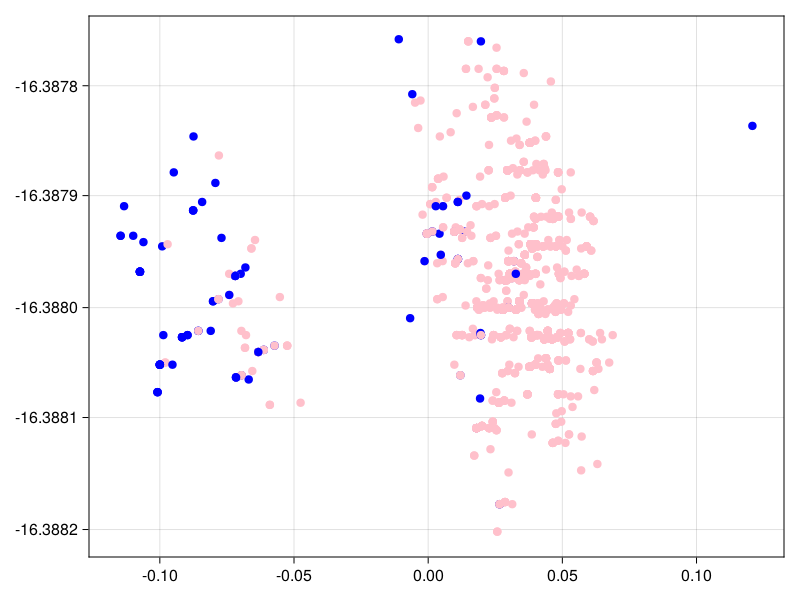

In [71]:
M = fit(MulticlassLDA, X_oh[:,plot_id],y[plot_id]; outdim=2)

data_transform = MultivariateStats.transform(M,X_oh[:,plot_id])

CairoMakie.scatter(data_transform,color = map(i->color_top_dict[i],y[plot_id]))

In [72]:
X_oh

30×1750 Matrix{Float64}:
 1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0     1.0  0.0  1.0  0.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0     0.0  1.0  1.0  0.0  0.0  0.0  1.0
 1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0     0.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

In [35]:
X_train = X_oh[:,train_id] |> transpose |> collect;
y_train = copy(y[train_id])

X_test = X_oh[:,test_id] |> transpose |> collect;
y_test = copy(y[test_id]);

In [36]:
model = DecisionTreeClassifier(max_depth=2,min_samples_leaf = 10)
DecisionTree.fit!(model, X_train, y_train)

DecisionTreeClassifier
max_depth:                2
min_samples_leaf:         10
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  ["4", "5"]
root:                     Decision Tree
Leaves: 4
Depth:  2

In [37]:
pred_yd_train = DecisionTree.predict(model, X_train)
pred_yd_test = DecisionTree.predict(model, X_test);

In [38]:
# r_train = counts(pred_yd_train,y_train)

print("Training accuracy: " * string(sum(pred_yd_train .== y_train) / length(y_train)))
print("\n")
print("Test accuracy: " * string(sum(pred_yd_test .== y_test) / length(y_test)))

Training accuracy: 0.8160714285714286
Test accuracy: 0.8

In [39]:
print_tree(model, 3)

Feature 16 < 0.5 ?
├─ Feature 28 < 0.5 ?
    ├─ 5 : 135/143
    └─ 4 : 40/68
└─ Feature 9 < 0.5 ?
    ├─ 4 : 178/191
    └─ 5 : 104/158


In [40]:
id = [16,28,9]

3-element Vector{Int64}:
 16
 28
  9

In [41]:
oh_feature_names[id]

3-element Vector{String}:
 "B=>C Act"
 "C=>B Inh"
 "C=>C Zer"

In [42]:
X_train_masked = zeros(size(X_train))
X_train_masked[:,id] = X_train[:,id]

@assert all(DecisionTree.predict_proba(model,X_train) .== DecisionTree.predict_proba(model,X_train_masked))

In [43]:
possible_three_top = reduce(hcat,[[i,j,k] for i=0:1 for j in 0:1 for k in 0:1]) |> transpose |> collect  ### this is wrong, mixing up -1,0,1 with id

X_three_top = zeros((size(possible_three_top,1),size(X_train,2)))

X_three_top[:,id] = possible_three_top

three_top_class_prob = DecisionTree.predict_proba(model,X_three_top);

In [44]:
X_plot = copy(X_test)
y_plot = copy(y_test)
y_class = ["4","5"];

# plot_id = findall(x->x in ["4","5"],y)

# X_plot = X_oh[:,plot_id] |> transpose |> collect
# y_plot = y[plot_id]
# y_class = ["4","5"];

2-element Vector{String}:
 "4"
 "5"

In [45]:
possible_three_top_dict = Dict(t |> collect =>i for (i,t) in enumerate(eachrow(possible_three_top)));

X_plot_top_id = countmap([possible_three_top_dict[r |> collect] for r in eachrow(X_plot[:,id])]);

X_plot_top_counts = [haskey(X_plot_top_id,top_id) ? X_plot_top_id[top_id] : 0 for top_id in 1:size(possible_three_top,1)];
X_plot_top_counts_class = [[haskey(X_plot_top_id,top_id) ? count(x->x==class,y_plot[findall(x->x==possible_three_top[top_id,:],eachrow(X_plot[:,id]))]) : 0 for top_id in 1:size(possible_three_top,1)] for class in y_class]

2-element Vector{Vector{Int64}}:
 [0, 0, 6, 0, 29, 10, 25, 0]
 [30, 0, 11, 0, 6, 22, 1, 0]

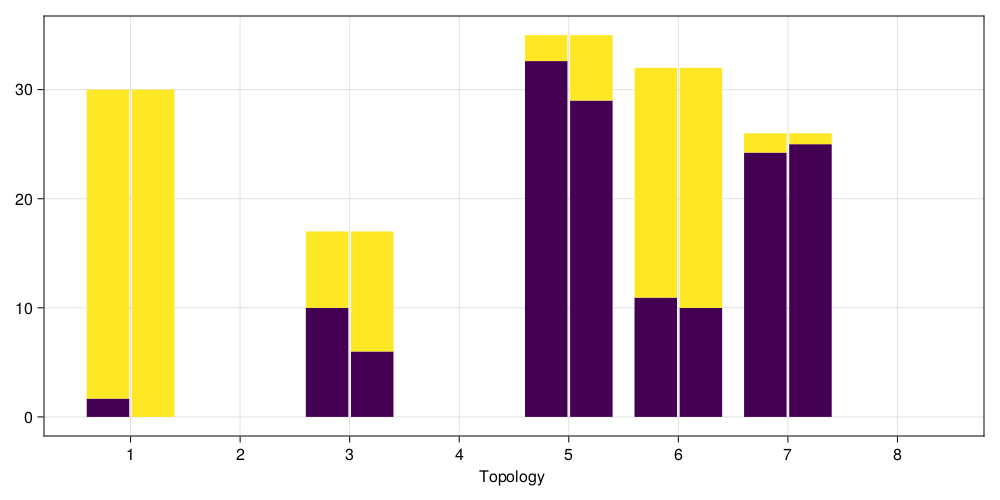

In [46]:
fig = CairoMakie.Figure(resolution =(1000,500))
ax = Axis(fig[1,1], xlabel = "Topology ")

x = 1:size(possible_three_top,1) |> collect

n_class = size(three_top_class_prob,2)

x_all = reduce(vcat,[x for i in 1:2*n_class]);

height_pred = reduce(vcat, [x.*X_plot_top_counts  for x in eachcol(three_top_class_prob) |> collect])

height_actual = [haskey(X_plot_top_id,top_id) ? X_plot_top_id[top_id] : 0 for top_id in 1:size(possible_three_top,1)];

height_all = vcat(height_pred,reduce(vcat,X_plot_top_counts_class))

class_grp = reduce(vcat,[i.*ones(Int,length(x)) for i in 1:n_class])

actual_class_grp = reduce(vcat,[n*ones(length(x)) for (n,x) in enumerate(X_plot_top_counts_class)])

all_class_grp = vcat(class_grp,actual_class_grp)

dodge_grp = vcat([1 for i in class_grp],[2 for i in actual_class_grp])

barplot!(ax,x_all, height_all,
        stack = Int.(all_class_grp),
        color = Int.(all_class_grp),
        dodge = dodge_grp,
        )

ax.xticks = (x,string.(x))

fig

In [47]:
# model = RandomForestClassifier(max_depth=2,min_samples_leaf = 10)
# DecisionTree.fit!(model, X_train, y_train)

In [48]:
# ?permutation_importance

In [49]:
using ScikitLearn: @sk_import, fit!, predict
@sk_import ensemble: RandomForestClassifier
@sk_import inspection: permutation_importance

┌ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
└ @ ScikitLearn.Skcore /Users/boothh/.julia/packages/ScikitLearn/sqLdT/src/Skcore.jl:191
┌ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment
└ @ Conda /Users/boothh/.julia/packages/Conda/xMClC/src/Conda.jl:127


done
Solving environment: ...working... 

done



# All requested packages already installed.



PyObject <function permutation_importance at 0x24875c820>

In [50]:
X_all = X_oh |> transpose |> collect;
y_all = copy(y);

In [76]:
forest = RandomForestClassifier(min_samples_leaf=10,n_estimators = 25)

use_trainset = true

if use_trainset

    forest.fit(X_train, y_train)

    pred_yf_train = [i for i in forest.predict(X_train)]
    pred_yf_test = [i for i in forest.predict(X_test)]


    print("Training accuracy: " * string(sum(pred_yf_train .== y_train) / length(y_train)))
    print("\n")
    print("Test accuracy: " * string(sum(pred_yf_test .== y_test) / length(y_test)))

else

    forest.fit(X_all, y_all)

    pred_yf_train = [i for i in forest.predict(X_all)]

    print("Training accuracy: " * string(sum(pred_yf_train .== y_all) / length(y_all)))
end

Training accuracy: 0.8660714285714286
Test accuracy: 0.8285714285714286

In [77]:
importances = forest.feature_importances_;

imp_order = sortperm(importances,rev= true)

std_importances = std(reduce(hcat,[tree.feature_importances_ for tree in forest.estimators_]),dims = 2)[imp_order];

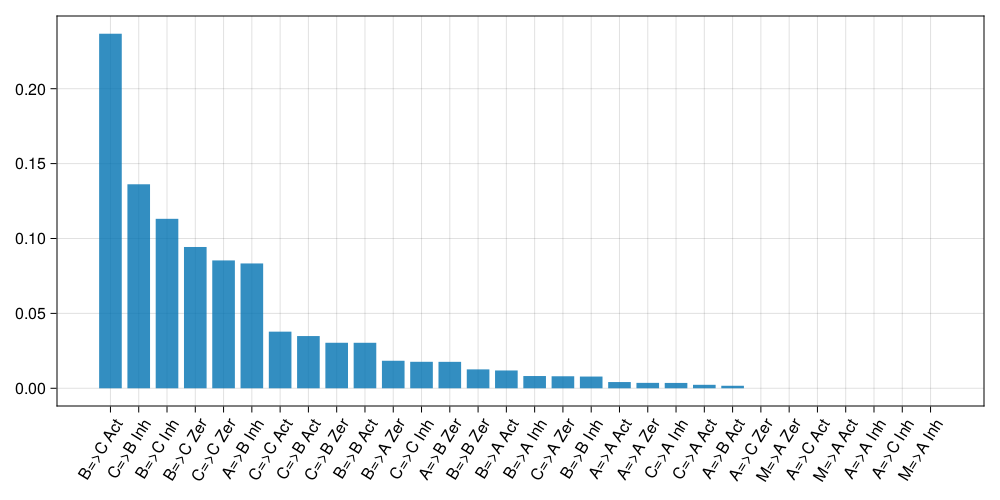

In [78]:
fig = CairoMakie.Figure(resolution = (1000,500))
ax = Axis(fig[1,1])

CairoMakie.barplot!(ax,importances[imp_order])

ax.xticks = (1:length(oh_feature_names),oh_feature_names[imp_order])

ax.xticklabelrotation= 45.

fig

In [79]:
perm_importances = permutation_importance(forest, X_all, y_all, n_repeats=10);

In [80]:
perm_importances_mean = perm_importances["importances_mean"];

In [81]:
perm_imp_order = sortperm(perm_importances_mean,rev= true);

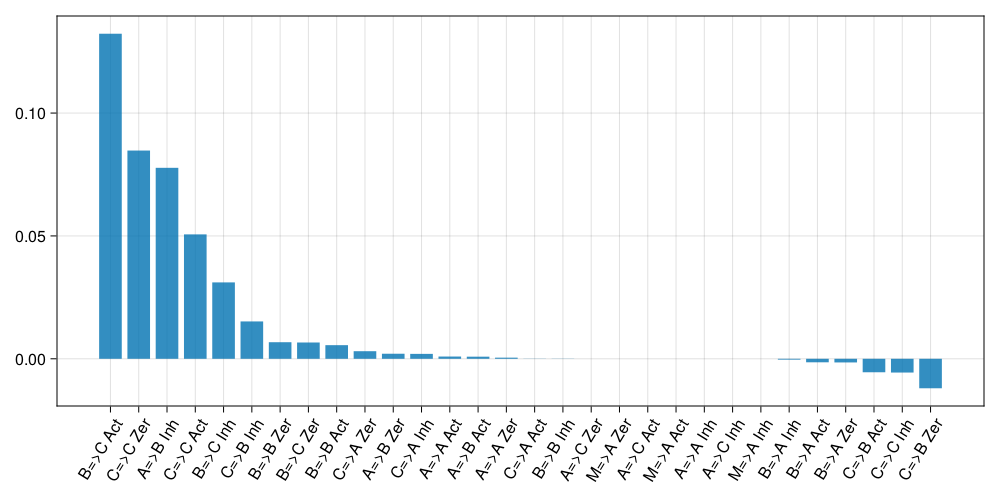

In [82]:
fig = CairoMakie.Figure(resolution = (1000,500))
ax = Axis(fig[1,1])

CairoMakie.barplot!(ax,perm_importances_mean[perm_imp_order])

ax.xticks = (1:length(oh_feature_names),oh_feature_names[perm_imp_order])

ax.xticklabelrotation= 45.

fig

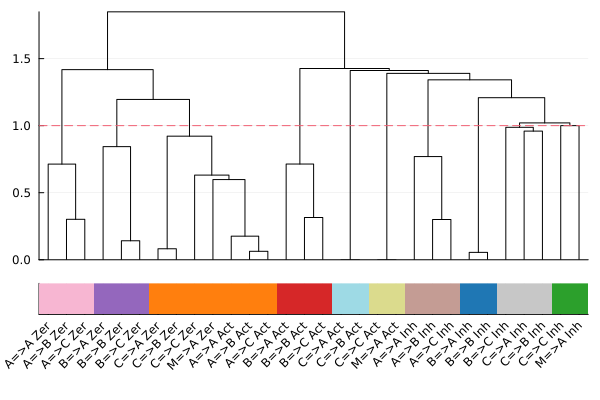

In [83]:
oh_corr = corspearman(X_oh |> transpose)

# oh_corr[isnan.(oh_corr)] .= 0.;

oh_corr[isnan.(oh_corr)] .= 0.;

fig = CairoMakie.Figure(resolution = (1000,1000))
ax = Axis(fig[1,1])

CairoMakie.heatmap!(ax,oh_corr)

ax.xticks = (1:length(oh_feature_names),oh_feature_names)

ax.xticklabelrotation= 45.

ax.yticks = (1:length(oh_feature_names),oh_feature_names)

ax.yticklabelrotation= 45.


############

corr_d = 1 .- abs.(oh_corr)

cu_thresh =  1.

hc1 = hclust(corr_d,linkage = :ward)

clust_labels = cutree(hc1,h = cu_thresh)

p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing),[cu_thresh],linestyle = :dash)
p2 = StatsPlots.heatmap(reshape(clust_labels[hc1.order],(1,length(clust_labels))),colorbar=false,yticks = false,xticks = (1:length(oh_feature_names),oh_feature_names),xrotation = 45.,colormap = cgrad(:tab20,categorical = true))

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

p_all = StatsPlots.plot(p1, p2, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("MSelection","Clust1Select.png"))

p_all

In [84]:
oh_feature_names[perm_imp_order[1:7]]

7-element Vector{String}:
 "B=>C Act"
 "C=>C Zer"
 "A=>B Inh"
 "C=>C Act"
 "B=>C Inh"
 "C=>B Inh"
 "B=>B Zer"

In [85]:
weight_names

10-element Vector{String}:
 "A=>A"
 "A=>B"
 "A=>C"
 "B=>A"
 "B=>B"
 "B=>C"
 "C=>A"
 "C=>B"
 "C=>C"
 "M=>A"

In [86]:
leg_weights = [6,8,2]

weight_names[leg_weights]

3-element Vector{String}:
 "B=>C"
 "C=>B"
 "A=>B"

In [87]:
y_entr = copy(y_all)
X_entr = copy(X)

unique_top_id = Dict(t=>i for (i,t) in enumerate(eachcol(unique(X_entr[leg_weights,:],dims = 2))))

top_assignment = [unique_top_id[t] for t in eachcol(X_entr[leg_weights,:])]

total_entropy = 0.

y_val = unique(y_all)

unique_topologies = unique(top_assignment)

p_vector_mat = zeros(length(y_val),length(unique_topologies))
c_vector_mat = zeros(length(y_val),length(unique_topologies))

for (n_top,top_assign) in enumerate(unique_topologies)

    top_assign_id = findall(x->x==top_assign,top_assignment)

    p_vector = zeros(length(y_val))
    c_vector = zeros(length(y_val))

    y_top_class = countmap(y[top_assign_id])

    for (n,class) in enumerate(y_val)

        if haskey(y_top_class,class)
            p_vector[n] = y_top_class[class] ./ length(top_assign_id)
            c_vector[n] = y_top_class[class] 
        else
            p_vector[n] = 0.
            c_vector[n] = 0.
        end
    end

    total_entropy += entropy(p_vector) 
    p_vector_mat[:,n_top] = p_vector
    c_vector_mat[:,n_top] = c_vector
end


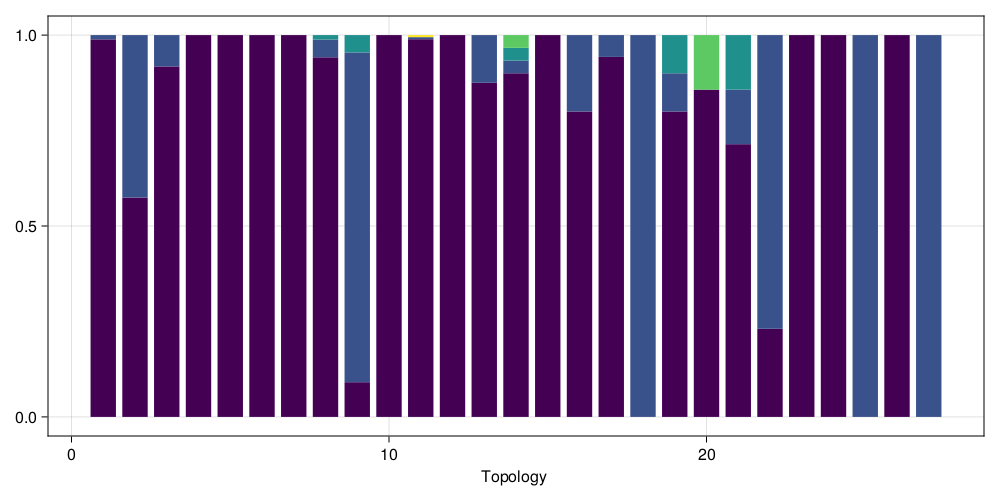

In [88]:

heights = reduce(vcat,eachcol(p_vector_mat))
stack_id = reduce(vcat,[[i for i in 1:size(p_vector_mat,1)] for j in eachcol(p_vector_mat)]);

x_all = reduce(vcat,[[j for i in 1:size(p_vector_mat,1)] for j in 1:size(p_vector_mat,2)]);

fig = CairoMakie.Figure(resolution =(1000,500))
ax = Axis(fig[1,1], xlabel = "Topology ")

barplot!(ax,x_all, heights,
        stack = stack_id,
        color = stack_id,
        )

fig

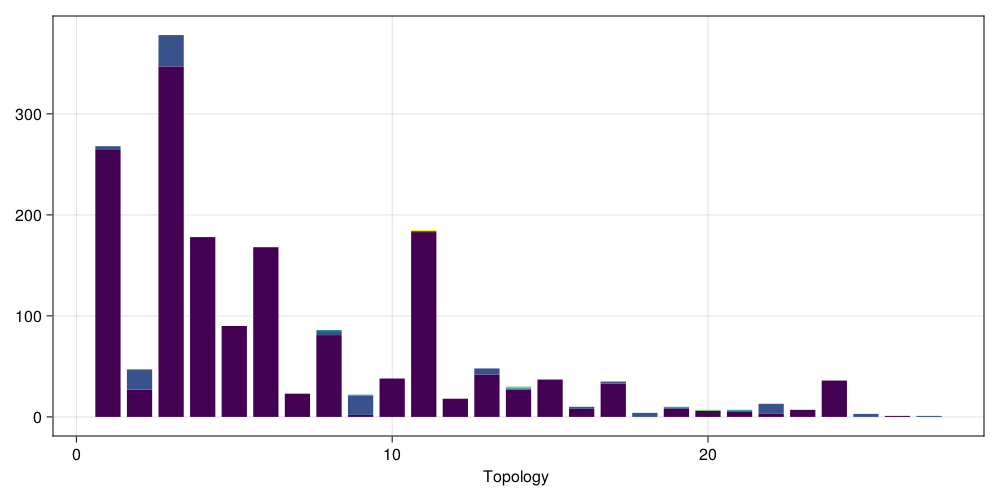

In [89]:

heights = reduce(vcat,eachcol(c_vector_mat))
stack_id = reduce(vcat,[[i for i in 1:size(c_vector_mat,1)] for j in eachcol(c_vector_mat)]);

x_all = reduce(vcat,[[j for i in 1:size(c_vector_mat,1)] for j in 1:size(c_vector_mat,2)]);

fig = CairoMakie.Figure(resolution =(1000,500))
ax = Axis(fig[1,1], xlabel = "Topology ")

barplot!(ax,x_all, heights,
        stack = stack_id,
        color = stack_id,
        )

fig

In [90]:
unique(X_entr[leg_weights,:],dims = 2)[:,4]

3-element Vector{Float64}:
 -1.0
  0.0
 -1.0

In [91]:
# Supervised clustering with SHAP feature attributions - since we get individualized feature contributions, can cluster these to identify different regimes before the hamming(0) transition

In [92]:
explainer = shap.TreeExplainer(forest) 

PyObject <shap.explainers._tree.Tree object at 0x248756d70>

In [93]:
shap_values = explainer.shap_values(X_train) 

2-element Vector{Matrix{Float64}}:
 [-0.0014697145293790749 0.006498224195375477 … -0.0025083080409066404 0.0; -0.00032337594466376875 -0.00954227757688697 … -0.004895616276519884 0.0; … ; 0.0011316838736646984 -0.014599296345337735 … -0.003916243437790275 0.0; 0.0035003694182856354 -0.014254855762191834 … -0.0048240552491336484 0.0]
 [0.0014697145293790744 -0.006498224195375479 … 0.0025083080409066412 0.0; 0.00032337594466376983 0.009542277576886974 … 0.004895616276519883 0.0; … ; -0.0011316838736646984 0.014599296345337747 … 0.003916243437790274 0.0; -0.0035003694182856367 0.014254855762191836 … 0.004824055249133649 0.0]

In [94]:
# shap.summary_plot(shap_values, X_train)

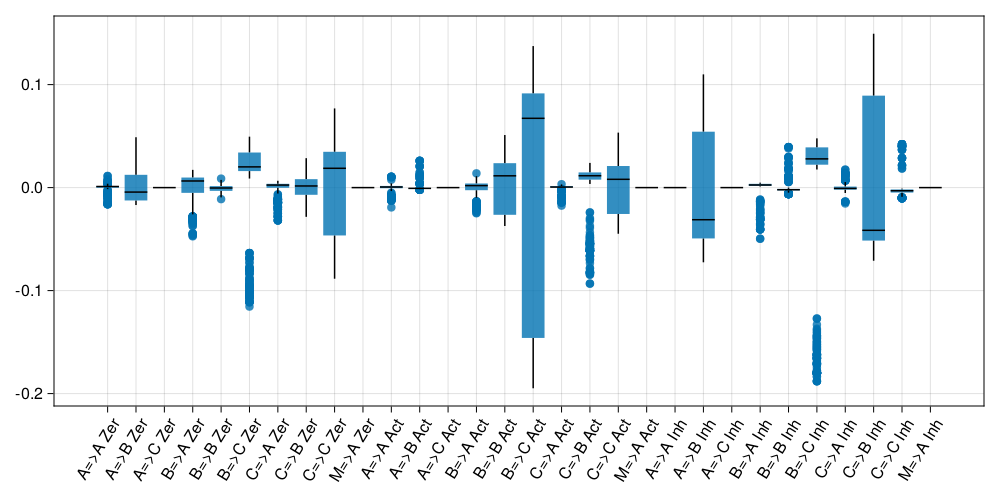

In [95]:
x_violin = reduce(vcat,[[n for _ in 1:length(col)] for (n,col) in enumerate(eachcol(shap_values[1]))])
y_violin = reduce(vcat,[col |> collect for (n,col) in enumerate(eachcol(shap_values[1]))])

fig = CairoMakie.Figure(resolution = (1000,500))
ax = Axis(fig[1,1])

CairoMakie.boxplot!(ax,[i for i in x_violin],[i for i in y_violin])

ax.xticks = (1:length(oh_feature_names),oh_feature_names)

ax.xticklabelrotation= 45.

fig

In [96]:
shap_dmat = pairwise(Euclidean(),shap_values[1],dims = 1);

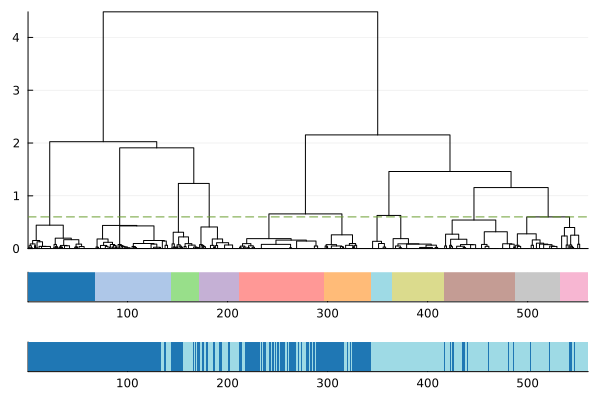

In [97]:
cu_thresh =  0.6

hc1 = hclust(shap_dmat,linkage = :ward)

clust_labels = cutree(hc1,h = cu_thresh)

p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing),[cu_thresh],linestyle = :dash)
p2 = StatsPlots.heatmap(reshape(clust_labels[hc1.order],(1,length(clust_labels))),colorbar=false,yticks = false,colormap = cgrad(:tab20,categorical = true))
p3 = StatsPlots.heatmap(reshape(y_train[hc1.order],(1,length(y_train))),colorbar=false,yticks = false,colormap = cgrad(:tab20,categorical = true))

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(3, 1,heights=[0.8,0.1,0.1])]

p_all = StatsPlots.plot(p1, p2,p3,layout=l)

# StatsPlots.savefig(p_all,plotsdirx("MSelection","Clust1Select.png"))

p_all

In [98]:
using UMAP

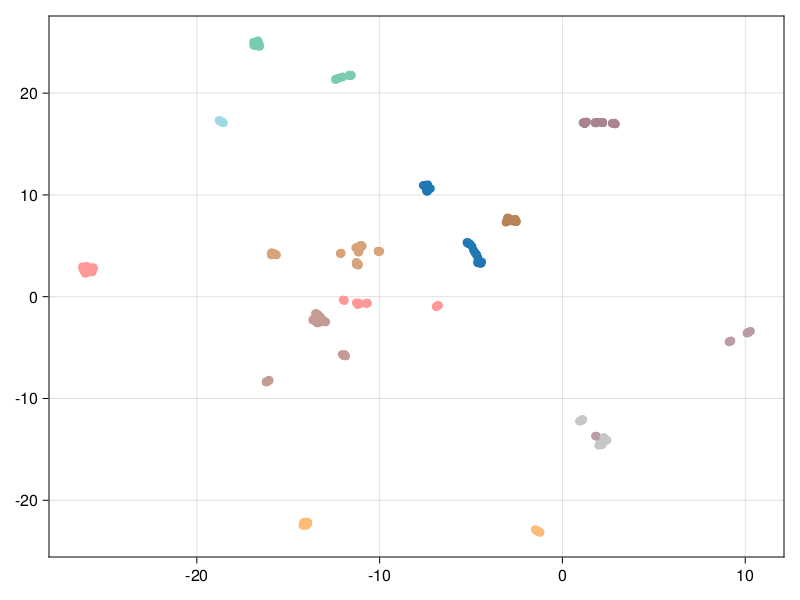

In [99]:
umap_shap = shap_values[1] |> transpose |> collect

embedding = umap(umap_shap, 2; n_neighbors = 80)

# CairoMakie.scatter(embedding,color = [x == "5" ? "pink" : "blue" for x in y_train])

CairoMakie.scatter(embedding,color = clust_labels,colormap = cgrad(:tab20,categorical = true))

In [100]:
sub_shap = []

for i in unique(clust_labels)
    sub_sample = copy(X_train[clust_labels .== i,:])

    shap_values = explainer.shap_values(sub_sample) 

    push!(sub_shap,(sub_sample,shap_values))
end

In [101]:
xgboost = pyimport("xgboost");

In [102]:
ytrain_n = [x == "5" ? 1 : 0 for x in y_train];
ytest_n = [x == "5" ? 1 : 0 for x in y_test];

In [103]:
d_train = xgboost.DMatrix(X_train, label=ytrain_n)
d_test = xgboost.DMatrix(X_test, label=ytest_n)

PyObject <xgboost.core.DMatrix object at 0x251f69600>

In [104]:
params = Dict(
    "eta"=> 0.01,
    "objective"=>"binary:logistic",
    "subsample"=> 0.5,
    "base_score"=>mean(ytrain_n),
    "eval_metric"=>"logloss"
)

model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=50)

[0]	test-logloss:0.68746
[100]	test-logloss:0.41879
[200]	test-logloss:0.34001
[300]	test-logloss:0.30969
[400]	test-logloss:0.30017
[500]	test-logloss:0.29518
[600]	test-logloss:0.29258
[700]	test-logloss:0.29218
[737]	test-logloss:0.29303


PyObject <xgboost.core.Booster object at 0x258f959f0>

In [105]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train);

In [106]:
# shap.summary_plot(shap_values, X_train)

In [107]:
explainer.expected_value

0.010822640731930733

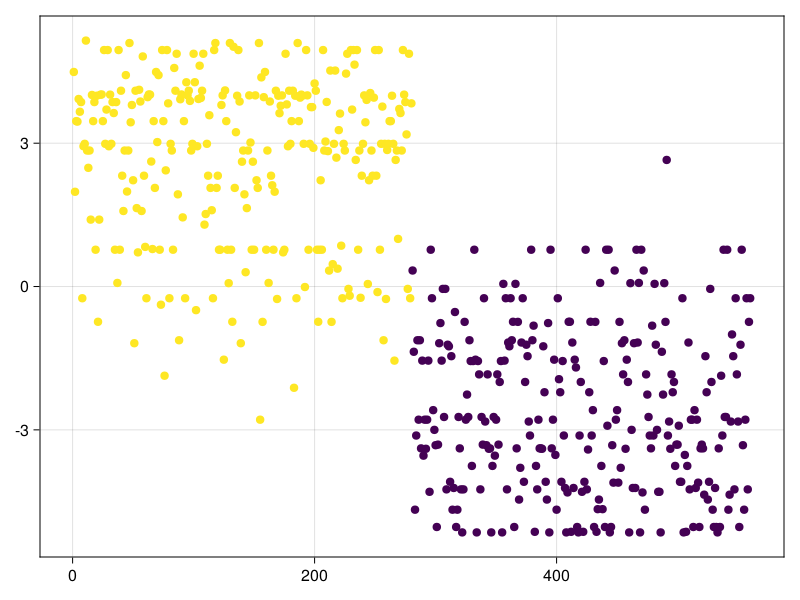

In [108]:
ll = explainer.expected_value .+ sum(shap_values,dims = 2)

CairoMakie.scatter(ll[:,1], color = ytrain_n)

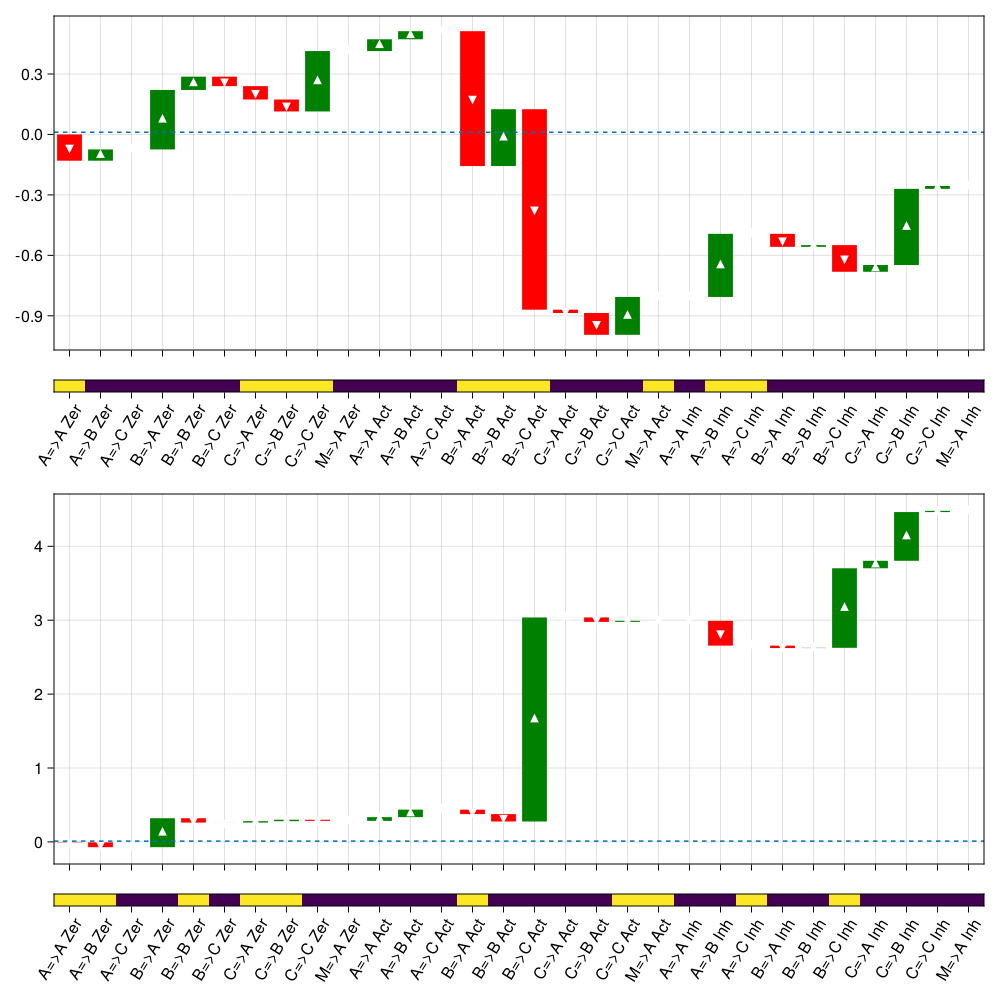

In [109]:
fig = CairoMakie.Figure(resolution = (1000,1000))

n_feature = size(shap_values,2)

ax1 = Axis(fig[1:10,1])
ax2 = Axis(fig[11,1])
ax3  = Axis(fig[12:22,1])
ax4  = Axis(fig[23,1])

CairoMakie.waterfall!(ax1,shap_values[end,:],show_direction=true,color = [x > 0 ? :green : :red for x in shap_values[end,:]])

CairoMakie.heatmap!(ax2,reshape(X_train[end,:],(n_feature,1)))

CairoMakie.waterfall!(ax3,shap_values[1,:],show_direction=true,color = [x > 0 ? :green : :red for x in shap_values[1,:]])

CairoMakie.heatmap!(ax4,reshape(X_train[1,:],(n_feature,1)))

CairoMakie.hlines!(ax1,explainer.expected_value, linestyle = :dash)

CairoMakie.hlines!(ax3,explainer.expected_value,linestyle = :dash)

# xspace = maximum(tight_xticklabel_spacing!, [ax1, ax2,ax3,ax4])

# ax1.xticklabelspace = xspace
# ax2.yticklabelspace = xspace
# ax3.xticklabelspace = xspace
# ax4.yticklabelspace = xspace

ax1.xticks = (1:length(oh_feature_names),oh_feature_names)
ax2.xticks = (1:length(oh_feature_names),oh_feature_names)
ax3.xticks = (1:length(oh_feature_names),oh_feature_names)
ax4.xticks = (1:length(oh_feature_names),oh_feature_names)

linkxaxes!([ax1,ax2,ax3,ax4]...)

hidexdecorations!(ax1, grid = false,ticks = false)
hidexdecorations!(ax3, grid = false,ticks = false)

hideydecorations!(ax2)
hideydecorations!(ax4)

ax2.xticklabelrotation = 45.
ax4.xticklabelrotation = 45.

fig

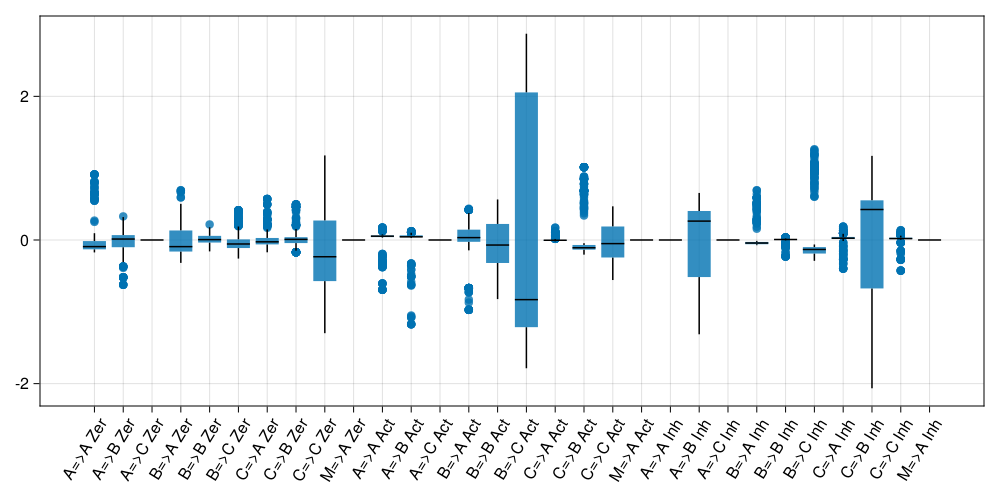

In [110]:
shap_values = explainer.shap_values(X_train);

x_violin = reduce(vcat,[[n for _ in 1:length(col)] for (n,col) in enumerate(eachcol(shap_values))])
y_violin = reduce(vcat,[col |> collect for (n,col) in enumerate(eachcol(shap_values))])

fig = CairoMakie.Figure(resolution = (1000,500))
ax = Axis(fig[1,1])

CairoMakie.boxplot!(ax,[i for i in x_violin],[i for i in y_violin])

ax.xticks = (1:length(oh_feature_names),oh_feature_names)

ax.xticklabelrotation= 45.

fig

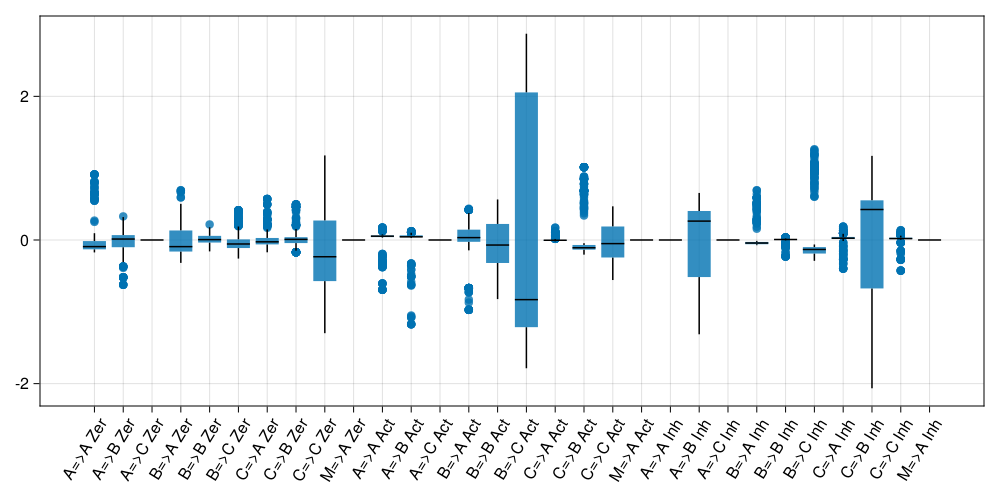

In [111]:
shap_values = explainer.shap_values(X_train);

x_violin = reduce(vcat,[[n for _ in 1:length(col)] for (n,col) in enumerate(eachcol(shap_values))])
y_violin = reduce(vcat,[col |> collect for (n,col) in enumerate(eachcol(shap_values))])
class_violin = reduce(vcat,[ytrain_n for (n,col) in enumerate(eachcol(shap_values))])
sign_violin = reduce(vcat,[col |> collect for (n,col) in enumerate(eachcol(X_train))])

fig = CairoMakie.Figure(resolution = (1000,500))
ax = Axis(fig[1,1])

CairoMakie.boxplot!(ax,[i for i in x_violin],[i for i in y_violin])

ax.xticks = (1:length(oh_feature_names),oh_feature_names)

ax.xticklabelrotation= 45.

fig

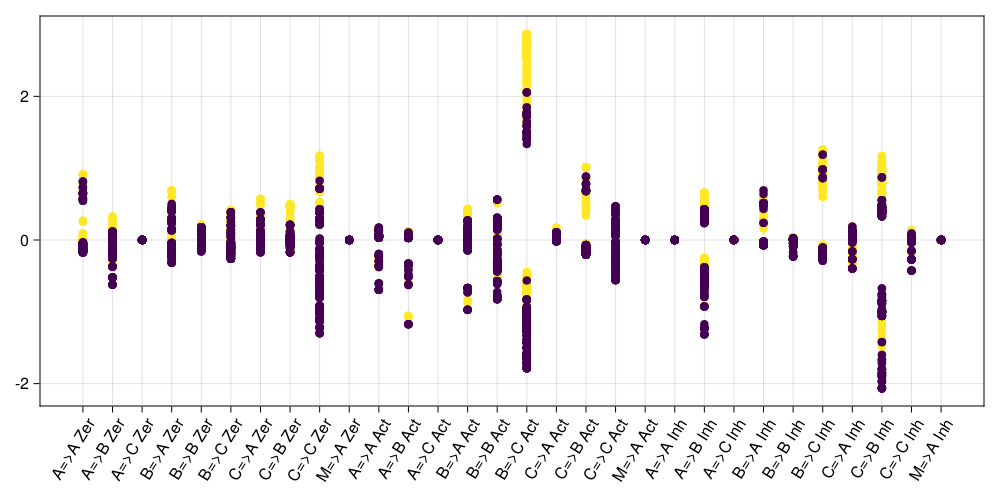

In [112]:
fig = CairoMakie.Figure(resolution = (1000,500))
ax = Axis(fig[1,1])

CairoMakie.scatter!(ax,[i for i in x_violin],[i for i in y_violin],color = class_violin )

ax.xticks = (1:length(oh_feature_names),oh_feature_names)

ax.xticklabelrotation= 45.

fig

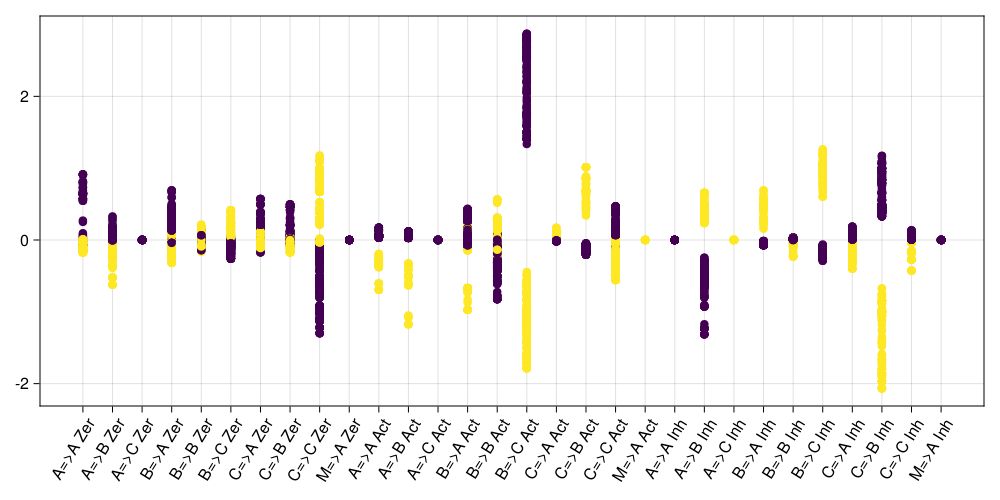

In [113]:
fig = CairoMakie.Figure(resolution = (1000,500))
ax = Axis(fig[1,1])

CairoMakie.scatter!(ax,[i for i in x_violin],[i for i in y_violin],color = sign_violin )

ax.xticks = (1:length(oh_feature_names),oh_feature_names)

ax.xticklabelrotation= 45.

fig